## Frozen Lake with Q-Learning

### Setup

First step: find course helpers library and update `sys.path` to find it.

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os, sys, subprocess

repo_url = "https://github.com/anton-dergunov/hugging-face-deep-rl.git"
target_dir = "hugging-face-deep-rl"
local_src = os.path.abspath("../src")

if os.path.isdir(local_src):
    repo_root = os.path.abspath("..")
    print("✅ Using local source for course helpers")
else:
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
    repo_root = os.path.abspath(target_dir)
    print("✅ Cloned repo with course helpers")

src_path = os.path.join(repo_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"🔧 sys.path updated with: {src_path}")

✅ Using local source for course helpers
🔧 sys.path updated with: /Users/anton/Dropbox/src/hugging-face-deep-rl/src


In [3]:
from rlcourse.system_setup import setup_env
setup_env()

🔧 Bootstrapping environment...
✅ swig already installed


📦 Packages installed
🔇 Warnings filtered
✅ Environment ready


In [93]:
import numpy as np
from tqdm.auto import tqdm
import gymnasium as gym
from IPython.display import Video

from rlcourse import gymnasium_utils

In [90]:
ENV_ID = "FrozenLake-v1"
MODEL_NAME = "FrozenLake_Q_Learning"

VIDEO_PATH = f"videos/{MODEL_NAME}.mp4"

os.makedirs(os.path.dirname(VIDEO_PATH), exist_ok=True)

### Environment

[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/): the task is to cross the lake from start (position [0,0] on the 2D grid) to the goal (last row, last column) without falling into any holes.

Some of the parameters of the environment:
- `map_name`: "4x4" or "8x8", loads a predefined map of the corresponding size
- `desc`: specfies custom map
- `is_slippery`: if true, then the player may "slip" and not always move in the indended direction

**Action space**: a number in the range `{0, 3}`:
- 0: move left
- 1: move down
- 2: move right
- 3: move up

**Observation space**: a value representing the player's current position as `current_row * ncols + current_col`.

**Rewards**:
- +1 for reaching the goal
- 0 for reaching a hole or a frozen cell

**Episode ends when**:
- Player moves into a hole
- Player reahes the goal
- Length of the episode is 100 (for "4x4" map) or 200 (for "8x8" map)

In [17]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

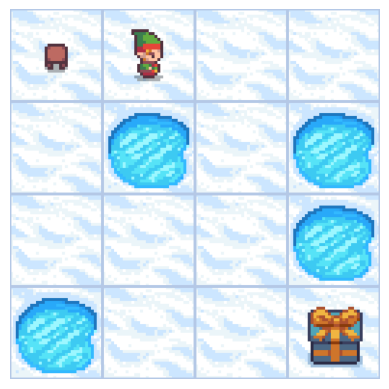

In [14]:
gymnasium_utils.show_environment(env)

In [12]:
gymnasium_utils.describe_environment(env)

hello___
Observation Space:
  Discrete(n=16)
  Example observation: 9

Action Space:
  Discrete(n=4)
  Example action: 1

Max episode steps: 100


### Q-Learning

Involves training Q-Function $Q(s,a)$ of a state $s$ and action $a$ in that state. It is encoded by a Q-Table.

**Hyperparameters**:
- $\alpha$ — learning rate (e.g. $0.1$)  
- $\gamma$ — discount factor (e.g. $0.99$)  
- $\epsilon$ — exploration probability for $\epsilon$-greedy (or use $\epsilon$-decay)

**Algorithm**:

1. Initialize $Q(s,a)$ arbitrarily for all states $s$ and actions $a$ (e.g. zeros).
2. For each episode:
   1. Initialize starting state $s$.
   2. Repeat until $s$ is terminal:
      - Choose action $a$ from $s$ using an $\epsilon$-greedy policy derived from $Q$.
      - Take action $a$, observe reward $r$ and next state $s'$.
      - Update:
        $$
        Q(s, a) \leftarrow Q(s, a) + \alpha\Big(r + \gamma \max_{a'} Q(s', a') - Q(s, a)\Big)
        $$
      - Set $s \leftarrow s'$.

In [ ]:
def init_q_table(env):
    state_space = env.observation_space.n
    action_space = env.action_space.n
    q_table = np.zeros((state_space, action_space))
    return q_table

In [37]:
def greedy_policy(q_table, state):
    return np.argmax(q_table[state])

def epsilon_greedy_policy(q_table, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(q_table.shape[1])
    else:
        return greedy_policy(q_table, state)

In [81]:
def q_learning(env, n_episodes, eps_start, eps_end, esp_decay, max_steps, lr, gamma):
    q_table = init_q_table(env)

    for episode in tqdm(range(n_episodes)):
        eps = eps_end + (eps_start - eps_end) * np.exp(-esp_decay * episode)

        state, _ = env.reset()

        for _ in range(max_steps):
            # Choose action using epsilon-greedy policy
            action = epsilon_greedy_policy(q_table, state, eps)

            # Take the action, observe reward and next state
            new_state, reward, terminated, truncated, _ = env.step(action)

            # Update Q-table Q(s,a)
            q_table[state, action] = q_table[state, action] + \
                lr * (reward + gamma * np.max(q_table[new_state]) - q_table[state, action])

            if terminated or truncated:
                break

            state = new_state
    return q_table

In [116]:
class QLearningAgent:
    def __init__(self, q_table):
        self.q_table = q_table

    def predict(self, obs, deterministic=True,  **kwargs):
        # TODO Handle deterministic
        actions = np.argmax(self.q_table[obs], axis=-1)
        return actions, None

### Case 1

In [120]:
env_kwargs = dict(map_name="4x4", is_slippery=False)

In [121]:
env_4by4 = gym.make("FrozenLake-v1", **env_kwargs, render_mode="rgb_array")

q_table_4by4 = q_learning(
    env_4by4,
    n_episodes = 10_000,
    eps_start = 1.0,
    eps_end = 0.01,
    esp_decay = 0.001,
    max_steps = 100,
    lr = 0.7,
    gamma = 0.95)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [125]:
model_4by4 = QLearningAgent(q_table_4by4)
print(gymnasium_utils.stable_evaluate(model_4by4, "FrozenLake-v1", env_kwargs=env_kwargs))

{'mean_reward': np.float64(1.0), 'std_reward': np.float64(0.0), 'ci_low': np.float64(1.0), 'ci_high': np.float64(1.0), 'n_total': 90}


In [126]:
gymnasium_utils.record_agent_video(model_4by4, ENV_ID, video_path=VIDEO_PATH, steps=100, env_kwargs=env_kwargs)

Saved video to videos/FrozenLake_Q_Learning.mp4


In [127]:
Video(VIDEO_PATH, embed=True)